In [5]:
# Imports & DB creation

In [1]:
# Imports
import pandas as pd
import sqlite3
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Create a SQLite DB (file: transactions.db) via SQLAlchemy engine
engine = create_engine('sqlite:///transactions.db', echo=False)
conn = engine.connect()

In [6]:
# Load CSV into SQLite using pandas

In [2]:
# Read CSV and push to SQLite table "transactions"
df = pd.read_csv("transactions.csv", parse_dates=["date"])
df.to_sql("transactions", engine, if_exists="replace", index=False)

# Quick peek
df.head()

,transaction_id,date,category,merchant,amount
0,1,2025-01-02,Food & Dining,Starbucks,5.75
1,2,2025-01-02,Transport,Uber,12.50
2,3,2025-01-03,Shopping,Amazon,45.20
3,4,2025-01-03,Food & Dining,McDonalds,8.10
4,5,2025-01-04,Utilities,Electric Company,120.00


In [7]:
# SELECT / WHERE examples (pandas + pure SQL)

In [4]:
# 1) SELECT * LIMIT 5 via SQL
q = "SELECT * FROM transactions LIMIT 5;"
pd.read_sql_query(q, engine)

# 2) WHERE: Food & Dining transactions
q = "SELECT * FROM transactions WHERE category = 'Food & Dining' ORDER BY date;"
pd.read_sql_query(q, engine)

,transaction_id,date,category,merchant,amount
0,1,2025-01-02 00:00:00.000000,Food & Dining,Starbucks,5.75
1,4,2025-01-03 00:00:00.000000,Food & Dining,McDonalds,8.10
2,8,2025-01-05 00:00:00.000000,Food & Dining,Subway,6.25
3,11,2025-01-07 00:00:00.000000,Food & Dining,KFC,10.50
4,14,2025-01-08 00:00:00.000000,Food & Dining,Starbucks,7.20
5,17,2025-01-10 00:00:00.000000,Food & Dining,Dominos,11.50


In [8]:
# GROUP BY and ORDER BY

In [9]:
# Total spent per category
q = """
SELECT category, 
       COUNT(*) AS tx_count,
       ROUND(SUM(amount),2) AS total_spent,
       ROUND(AVG(amount),2) AS avg_spend
FROM transactions
GROUP BY category
ORDER BY total_spent DESC;
"""
pd.read_sql_query(q, engine)

,category,tx_count,total_spent,avg_spend
0,Shopping,5,1440.45,288.09
1,Utilities,3,210.75,70.25
2,Transport,4,49.45,12.36
3,Food & Dining,6,49.30,8.22
4,Entertainment,2,25.98,12.99


In [10]:
# Aggregation + time-series (daily spend)

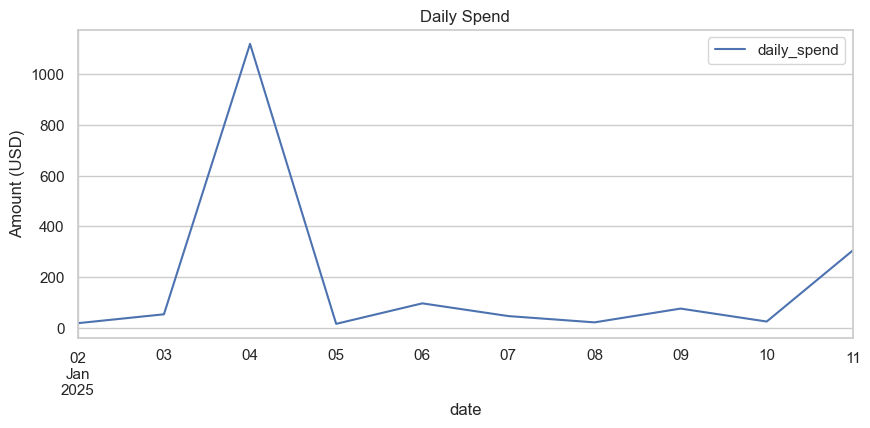

In [11]:
q = """
SELECT date, ROUND(SUM(amount),2) AS daily_spend
FROM transactions
GROUP BY date
ORDER BY date;
"""
daily = pd.read_sql_query(q, engine, parse_dates=["date"])
daily.set_index("date", inplace=True)
daily.plot(kind="line", figsize=(10,4), title="Daily Spend")
plt.ylabel("Amount (USD)")
plt.show()

In [12]:
# JOIN example (create small categories table then join)

In [13]:
# Create a categories lookup table (for demonstration)
categories = pd.DataFrame({
    "category": ["Food & Dining","Transport","Shopping","Utilities","Entertainment"],
    "category_group": ["Living","Transport","Shopping","Bills","Leisure"]
})
categories.to_sql("categories", engine, if_exists="replace", index=False)

# INNER JOIN: attach category_group to each transaction
q = """
SELECT t.transaction_id, t.date, t.merchant, t.amount, t.category, c.category_group
FROM transactions t
INNER JOIN categories c
  ON t.category = c.category
ORDER BY t.date;
"""
pd.read_sql_query(q, engine, parse_dates=["date"]).head()

,transaction_id,date,merchant,amount,category,category_group
0,1,2025-01-02,Starbucks,5.75,Food & Dining,Living
1,2,2025-01-02,Uber,12.50,Transport,Transport
2,3,2025-01-03,Amazon,45.20,Shopping,Shopping
3,4,2025-01-03,McDonalds,8.10,Food & Dining,Living
4,5,2025-01-04,Electric Company,120.00,Utilities,Bills


In [14]:
# Window functions (rolling sums) — fallback using pandas if SQLite lacks window support

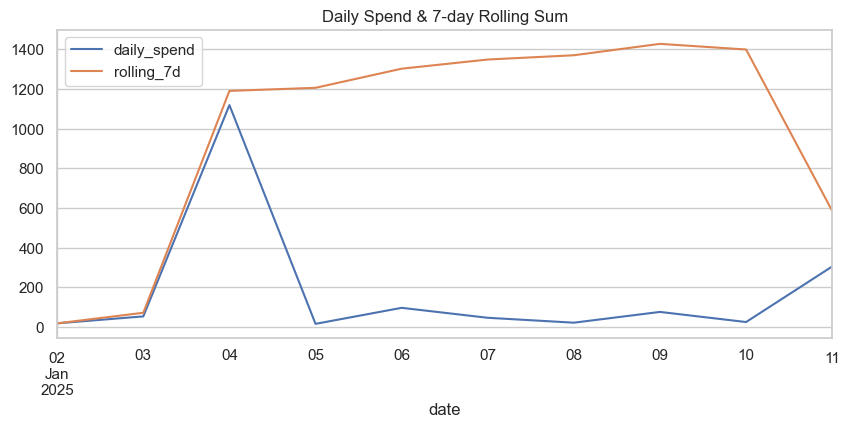

In [15]:
# Option 1: If your SQLite supports window functions, you can run SQL like:
# SELECT date, SUM(amount) OVER (ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS rolling_7d FROM transactions;

# Safer general approach: use pandas for rolling sums
daily['rolling_7d'] = daily['daily_spend'].rolling(window=7, min_periods=1).sum()
daily[['daily_spend','rolling_7d']].plot(figsize=(10,4), title="Daily Spend & 7-day Rolling Sum")
plt.show()

In [16]:
# Top merchants & visualization

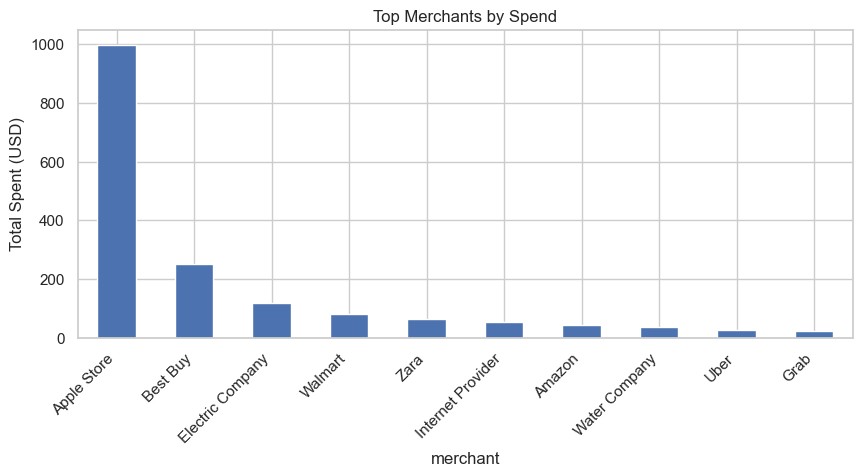

In [17]:
q = """
SELECT merchant, ROUND(SUM(amount),2) AS total_spent
FROM transactions
GROUP BY merchant
ORDER BY total_spent DESC
LIMIT 10;
"""
top_merchants = pd.read_sql_query(q, engine)
top_merchants.plot.bar(x='merchant', y='total_spent', legend=False, figsize=(10,4), title="Top Merchants by Spend")
plt.ylabel("Total Spent (USD)")
plt.xticks(rotation=45, ha='right')
plt.show()

In [18]:
cleaned = pd.read_sql_query("SELECT * FROM transactions", engine, parse_dates=["date"])
cleaned.to_csv("transactions_cleaned.csv", index=False)
print("Exported transactions_cleaned.csv")

Exported transactions_cleaned.csv
